# Package

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# importation des donn√©es

In [2]:
df_stationary_train = pd.read_csv("df_stationary_train.csv", index_col="date")
df_stationary_train.index = pd.to_datetime(df_stationary_train.index)
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = pd.to_datetime(df_stationary_test.index)

In [3]:
df_stationary_train

UNRATE  TB3MS       RPI    INDPRO  DPCERA3M086SBEA   S&P 500  \
date                                                                       
1960-01-31    -0.8   0.30  0.020977  0.091980         0.001204  0.017909   
1960-02-29    -1.1  -0.19  0.014565  0.076964         0.006009 -0.025663   
1960-03-31    -0.2  -1.18  0.006250  0.007961         0.021240 -0.070857   
1960-04-30     0.0  -1.12  0.006489 -0.025915         0.033752 -0.040442   
1960-05-31     0.0  -0.67  0.007747 -0.018121         0.009040 -0.010090   
...            ...    ...       ...       ...              ...       ...   
1989-07-31    -0.2  -0.77  0.001769 -0.015259         0.003755  0.093414   
1989-08-31    -0.4  -0.53  0.008277 -0.000039         0.014490  0.099097   
1989-09-30    -0.1  -0.40  0.008246 -0.003350         0.010644  0.070372   
1989-10-31    -0.1  -0.24  0.009738  0.005091         0.007003  0.045643   
1989-11-30     0.1  -0.21  0.008571 -0.001243        -0.002069 -0.018638   

            BUSLOANS  CPIAUCSL  OILPRICEx      M2SL  USREC  
date                                                        
1960-01-31  0.011578 -0.006156   0.000000  0.001323      0  
1960-02-29  0.011905 -0.003767   0.000000  0.002007      0  
1960-03-31 -0.008356 -0.005455   0.000000  0.001324      0  
1960-04-30 -0.009098  0.005090   0.000000  0.000634      1  
1960-05-31 -0.000359  0.003383   0.000000  0.003977      1  
...              ...       ...        ...       ...    ...  
1989-07-31 -0.002184 -0.004246  -0.225652  0.010549      0  
1989-08-31  0.005449 -0.010676  -0.195045  0.014176      0  
1989-09-30  0.007701 -0.009804  -0.049151  0.011753      0  
1989-10-31 -0.005351 -0.004106   0.091153  0.004694      0  
1989-11-30 -0.009885  0.004736   0.146104 -0.001661      0  

[359 rows x 11 columns]

In [4]:
df_stationary_train_unrate = df_stationary_train["UNRATE"]
df_stationary_test_unrate = df_stationary_test["UNRATE"]

In [33]:
df_stationary_train_unrate.head()

date
1960-01-31   -0.8
1960-02-29   -1.1
1960-03-31   -0.2
1960-04-30    0.0
1960-05-31    0.0
Name: UNRATE, dtype: float64

In [37]:
df_stationary_train_unrate

date
1960-01-31   -0.8
1960-02-29   -1.1
1960-03-31   -0.2
1960-04-30    0.0
1960-05-31    0.0
             ... 
1989-07-31   -0.2
1989-08-31   -0.4
1989-09-30   -0.1
1989-10-31   -0.1
1989-11-30    0.1
Name: UNRATE, Length: 359, dtype: float64

# AR(1)

## Autocorr√©lation

<Figure size 640x480 with 0 Axes>

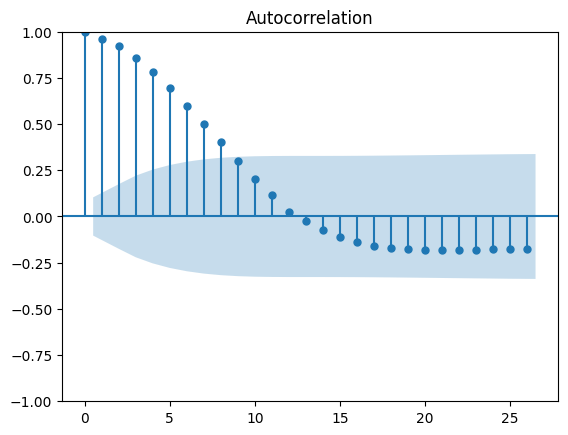

In [6]:
plt.figure()
plot_acf(df_stationary_train_unrate)
plt.show()

<Figure size 640x480 with 0 Axes>

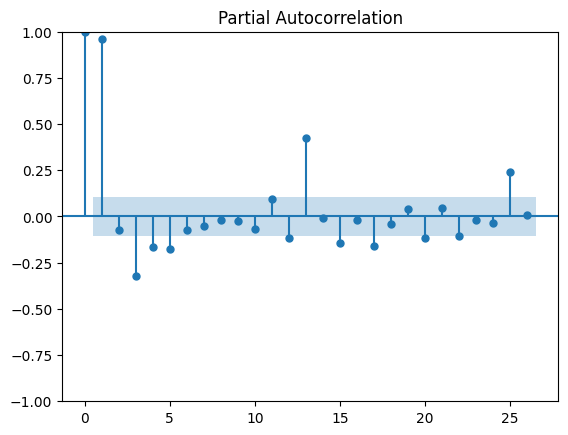

In [7]:
plt.figure()
plot_pacf(df_stationary_train_unrate)
plt.show()

Le graphique ACF montre une d√©croissance progressive et r√©guli√®re vers z√©ro ‚Üí typique d‚Äôun processus autor√©gressif (AR).

Le graphique PACF pr√©sente une coupure nette apr√®s le lag 1, c‚Äôest-√†-dire que seule la premi√®re autocorr√©lation partielle est significative.

La s√©rie suit tr√®s probablement un mod√®le AR(1) (autor√©gressif d‚Äôordre 1).

# Impl√©mentation de AR(1)

In [18]:
# ==========================================
# AR(1) ‚Äî Pr√©visions OOS h=12 (expanding) + √âvaluation 1983‚Äì1989
# ==========================================
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------- 0) S√©rie cible (ŒîUNRATE d√©j√† diff√©renci√©e) --------
y = df_stationary_train_unrate.squeeze().sort_index().astype(float).dropna()

# index mensuel d√©but de mois
y.index = pd.to_datetime(y.index).to_period("M").to_timestamp(how="start")
y = y.asfreq("MS")

# garde-fou : fr√©quence r√©guli√®re
assert y.index.freq == "MS", "Index non r√©gulier (MS). V√©rifie qu'il n'y a pas de mois manquant."

print(f"y: {y.index.min().date()} ‚Üí {y.index.max().date()}  (n={len(y)}) | freq={y.index.freqstr}")

# -------- 1) Param√®tres --------
h = 12
min_train_n = 36          # ‚â• 3 ans
eval_start = pd.Timestamp("1983-01-01")
eval_end   = pd.Timestamp("1989-12-31")

# -------- 2) Boucle expanding + pr√©vision √† h --------
rows = []
last_model = None
last_fit_end = None

last_t_end = y.index.max() - relativedelta(months=h)

for t_end in y.index:
    if t_end > last_t_end:
        break

    y_tr = y.loc[:t_end]
    if len(y_tr) < min_train_n:
        continue

    # AR(1) avec constante (trend='c'). Mettre trend='n' si vous ne voulez pas de constante.
    ar1 = AutoReg(y_tr, lags=1, old_names=False, trend='c').fit()
    last_model = ar1
    last_fit_end = t_end

    # pr√©vision r√©cursive jusqu'√† h, on prend la valeur √† l'horizon
    fc = ar1.predict(start=len(y_tr), end=len(y_tr) + h - 1)
    yhat_h = float(fc.iloc[-1])

    t_fore = t_end + relativedelta(months=h)
    if t_fore in y.index:
        rows.append((t_fore, yhat_h, float(y.loc[t_fore])))

# -------- 3) Agr√©gation des pr√©visions --------
if rows:
    df_oos_ar1 = (
        pd.DataFrame(rows, columns=["date", "y_hat", "y_true"])
          .set_index("date")
          .sort_index()
    )
else:
    df_oos_ar1 = pd.DataFrame(columns=["y_hat", "y_true"])
    df_oos_ar1.index = pd.to_datetime(pd.Index([]))
    print("‚ö†Ô∏è Pas de pr√©visions g√©n√©r√©es (v√©rifie la longueur de y / min_train_n).")

print(f"n pr√©visions g√©n√©r√©es: {len(df_oos_ar1)} | fen√™tre d‚Äô√©val: {eval_start.date()}‚Äì{eval_end.date()}")

# -------- 4) √âvaluation 1983‚Äì1989 --------
df_eval = df_oos_ar1.loc[eval_start:eval_end].copy()

if len(df_eval) > 0:
    mae  = mean_absolute_error(df_eval["y_true"], df_eval["y_hat"])
    rmse = float(np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_hat"])))
    r2   = r2_score(df_eval["y_true"], df_eval["y_hat"]) if len(df_eval) > 1 else np.nan

    print(f"\n‚úÖ AR(1) OOS (h=12) ‚Äî √âvaluation 1983‚Äì1989 ‚Äî n={len(df_eval)}")
    print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R¬≤ = {r2:.3f}")

    # ---- D√©tails annuels (sans FutureWarning) ----
    err = df_eval["y_true"] - df_eval["y_hat"]
    tmp = df_eval.assign(
        year=df_eval.index.year,
        AE=np.abs(err),
        SE=err**2,
    )
    yearly = tmp.groupby("year").agg(
        n=("y_true", "size"),
        MAE=("AE", "mean"),
        RMSE=("SE", lambda s: float(np.sqrt(s.mean()))),
    )
    print("\n--- MAE/RMSE par ann√©e (1983‚Äì1989) ---")
    print(yearly.to_string())
else:
    print("‚ö†Ô∏è Aucune observation dans la fen√™tre 1983‚Äì1989.")

# df_oos_ar1 contient toutes les pr√©visions OOS ; df_eval la tranche 1983‚Äì1989.

y: 1960-01-01 ‚Üí 1989-11-01  (n=359) | freq=MS
n pr√©visions g√©n√©r√©es: 312 | fen√™tre d‚Äô√©val: 1983-01-01‚Äì1989-12-31

‚úÖ AR(1) OOS (h=12) ‚Äî √âvaluation 1983‚Äì1989 ‚Äî n=83
MAE = 0.978 | RMSE = 1.461 | R¬≤ = -1.724

--- MAE/RMSE par ann√©e (1983‚Äì1989) ---
       n       MAE      RMSE
year                        
1983  12  1.895235  2.356209
1984  12  2.257664  2.595748
1985  12  1.129074  1.240798
1986  12  0.175455  0.232867
1987  12  0.787346  0.818619
1988  12  0.301074  0.381930
1989  11  0.235163  0.265309


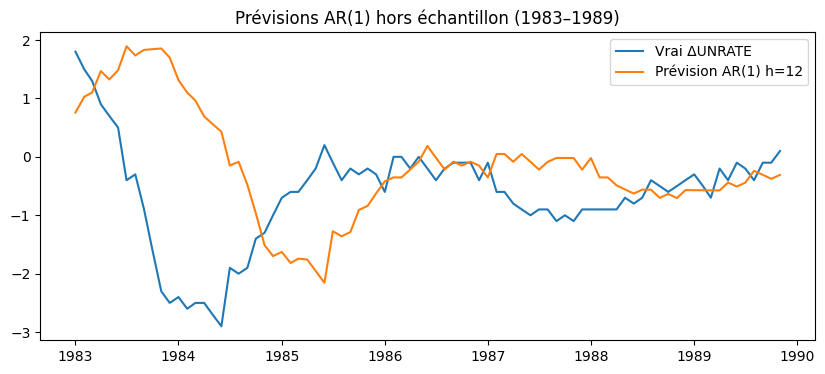

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_eval.index, df_eval["y_true"], label="Vrai ŒîUNRATE")
plt.plot(df_eval.index, df_eval["y_hat"], label="Pr√©vision AR(1) h=12")
plt.legend()
plt.title("Pr√©visions AR(1) hors √©chantillon (1983‚Äì1989)")
plt.show()

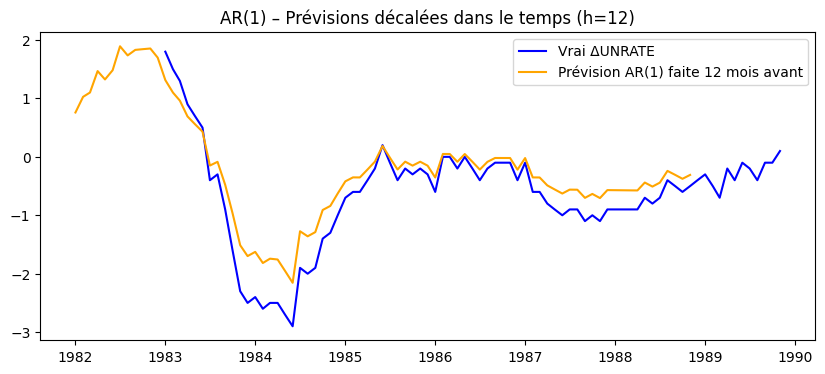

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10,4))
plt.plot(df_eval.index, df_eval["y_true"], label="Vrai ŒîUNRATE", color="blue")
plt.plot(df_eval.index - pd.DateOffset(months=12),
         df_eval["y_hat"], label="Pr√©vision AR(1) faite 12 mois avant", color="orange")

plt.title("AR(1) ‚Äì Pr√©visions d√©cal√©es dans le temps (h=12)")
plt.legend()
plt.show()

In [22]:
# S√©rie d'erreurs (align√©e : vraie √©valuation)
err = df_eval["y_true"] - df_eval["y_hat"]

diag = pd.DataFrame({
    "y_true": df_eval["y_true"],
    "y_hat":  df_eval["y_hat"],
    "abs_err": err.abs()
})
print("Top 10 des plus grosses erreurs (align√©es) :")
print(diag.sort_values("abs_err", ascending=False).head(10))

Top 10 des plus grosses erreurs (align√©es) :
            y_true     y_hat   abs_err
date                                  
1983-12-01    -2.5  1.698242  4.198242
1983-11-01    -2.3  1.854377  4.154377
1984-01-01    -2.4  1.313720  3.713720
1984-02-01    -2.6  1.099760  3.699760
1984-03-01    -2.5  0.962314  3.462314
1983-10-01    -1.6  1.842806  3.442806
1984-06-01    -2.9  0.430400  3.330400
1984-05-01    -2.7  0.560589  3.260589
1984-04-01    -2.5  0.691926  3.191926
1983-09-01    -0.9  1.830815  2.730815


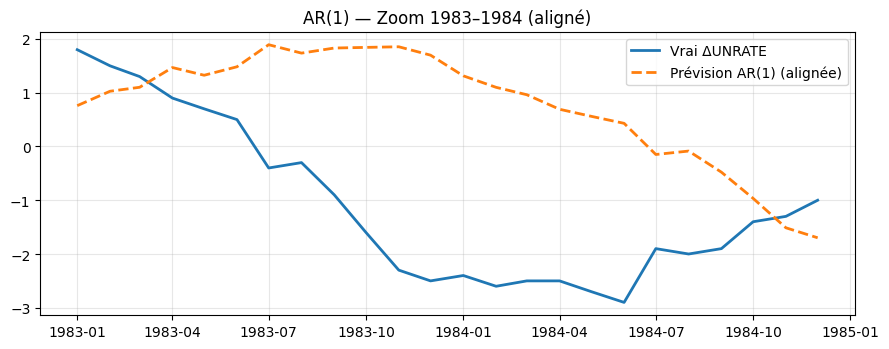

In [23]:
import matplotlib.pyplot as plt

z = df_eval.loc["1983":"1984", ["y_true","y_hat"]]
plt.figure(figsize=(9,3.6))
plt.plot(z.index, z["y_true"], label="Vrai ŒîUNRATE", lw=2)
plt.plot(z.index, z["y_hat"],  label="Pr√©vision AR(1) (align√©e)", lw=2, ls="--")
plt.title("AR(1) ‚Äî Zoom 1983‚Äì1984 (align√©)")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

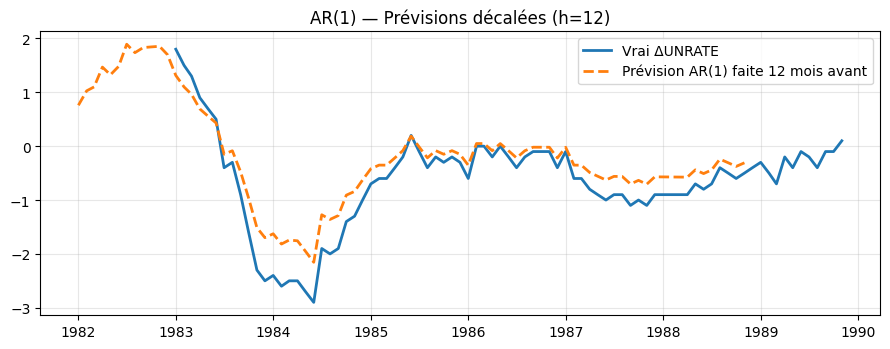

In [24]:
plt.figure(figsize=(9,3.6))
plt.plot(df_eval.index, df_eval["y_true"], label="Vrai ŒîUNRATE", lw=2)
plt.plot(df_eval.index - pd.DateOffset(months=12),
         df_eval["y_hat"], label="Pr√©vision AR(1) faite 12 mois avant", lw=2, ls="--")
plt.title("AR(1) ‚Äî Pr√©visions d√©cal√©es (h=12)")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

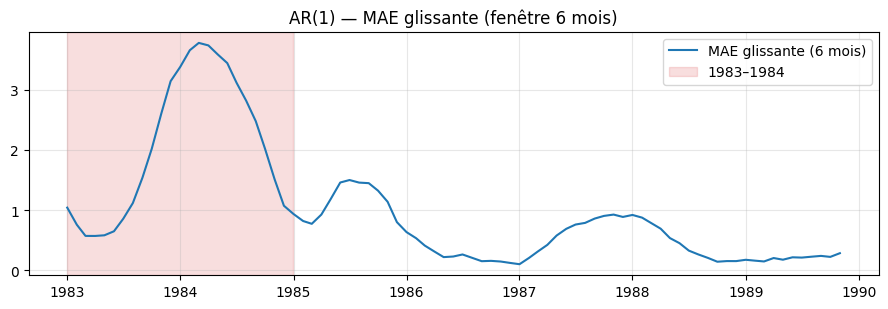

In [25]:
roll_mae = err.abs().rolling(6, min_periods=1).mean()
plt.figure(figsize=(9,3.2))
plt.plot(roll_mae.index, roll_mae, label="MAE glissante (6 mois)")
plt.axvspan(pd.Timestamp("1983-01-01"), pd.Timestamp("1984-12-31"),
            color="tab:red", alpha=0.15, label="1983‚Äì1984")
plt.title("AR(1) ‚Äî MAE glissante (fen√™tre 6 mois)")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

In [26]:
by_year = (
    df_eval.assign(year=df_eval.index.year)
           .groupby("year")
           .apply(lambda g: pd.Series({
               "n": len(g),
               "MAE": mean_absolute_error(g["y_true"], g["y_hat"]),
               "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_hat"]))
           }))
)
print(by_year.loc[1983:1984])

         n       MAE      RMSE
year                          
1983  12.0  1.895235  2.356209
1984  12.0  2.257664  2.595748


C:\Users\Mita\AppData\Local\Temp\ipykernel_2512\66949015.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [27]:
true_smooth = df_eval["y_true"].rolling(6, min_periods=1).mean()
mae_raw    = mean_absolute_error(df_eval["y_true"], df_eval["y_hat"])
mae_smooth = mean_absolute_error(true_smooth, df_eval["y_hat"])
print(f"MAE vs y_true        : {mae_raw:.3f}")
print(f"MAE vs y_true (liss√©): {mae_smooth:.3f}")

MAE vs y_true        : 0.978
MAE vs y_true (liss√©): 0.795


In [28]:
# ==========================================
# AR(1) OOS h=12 ‚Äî bundle compatible lin√©aire
# ==========================================
import numpy as np
import pandas as pd
import joblib
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --------- 0) Utilitaires ---------
def normalize_month_start(series_like):
    """
    Convertit en Timestamp d√©but de mois (freq MS).
    Accepte Series/array/list de dates.
    """
    s = pd.to_datetime(series_like, errors="coerce")
    # important : utiliser l'accessor .dt pour √©viter l'erreur RangeIndex
    return s.dt.to_period("M").dt.to_timestamp(how="start")

# --------- 1) S√©rie cible (ŒîUNRATE) ---------
# Hypoth√®se : df_stationary_train_unrate existe (Series/DataFrame une colonne)
y = df_stationary_train_unrate.squeeze().sort_index().astype(float).dropna()

# Index mensuel (d√©but de mois)
y.index = pd.to_datetime(y.index)
y.index = y.index.to_period("M").to_timestamp(how="start")
y = y.asfreq("MS")

# --------- 2) Param√®tres ---------
h = 12
min_train_n = 36            # au moins 3 ans
eval_start = pd.Timestamp("1983-01-01")
eval_end   = pd.Timestamp("1989-12-31")

# --------- 3) Pr√©visions OOS (expanding, horizon h=12) ---------
rows = []
last_model = None
last_fit_end = None

last_t_end = y.index.max() - relativedelta(months=h)

for t_end in y.index:
    if t_end > last_t_end:
        break

    y_tr = y.loc[:t_end].dropna()
    if len(y_tr) < min_train_n:
        continue

    ar1 = AutoReg(y_tr, lags=1, old_names=False).fit()
    last_model = ar1
    last_fit_end = t_end

    # forecast r√©cursif jusqu'√† h
    fc = ar1.predict(start=len(y_tr), end=len(y_tr) + h - 1)
    yhat_h = float(fc.iloc[-1])

    t_fore = t_end + relativedelta(months=h)
    if t_fore in y.index:
        rows.append((t_fore, yhat_h, float(y.loc[t_fore])))

# Agr√©gation
if rows:
    df_oos_ar1 = (
        pd.DataFrame(rows, columns=["date", "y_hat", "y_true"])
        .set_index("date")
        .sort_index()
    )
else:
    df_oos_ar1 = pd.DataFrame(columns=["y_hat", "y_true"])
    df_oos_ar1.index = pd.to_datetime(pd.Index([]))
    print("‚ö†Ô∏è Pas de pr√©visions g√©n√©r√©es (v√©rifie la longueur de y).")

# --------- 4) √âvaluation sur 1983‚Äì1989 ---------
df_eval = df_oos_ar1.loc[eval_start:eval_end].copy()

metrics = {}
if len(df_eval) > 0:
    mae  = mean_absolute_error(df_eval["y_true"], df_eval["y_hat"])
    rmse = np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_hat"]))
    r2   = r2_score(df_eval["y_true"], df_eval["y_hat"]) if len(df_eval) > 1 else np.nan
    metrics = {"MAE": float(mae), "RMSE": float(rmse), "R2": (None if np.isnan(r2) else float(r2))}
    print(f"\n‚úÖ AR(1) OOS (h=12) ‚Äî √âvaluation 1983‚Äì1989 ‚Äî n={len(df_eval)}")
    print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R¬≤ = {r2:.3f}")
else:
    print("‚ö†Ô∏è Aucune observation dans la fen√™tre 1983‚Äì1989.")

# --------- 5) oos_predictions NORMALIS√â (format compatible) ---------
oos = (
    df_oos_ar1.loc[eval_start:eval_end, ["y_true", "y_hat"]]
    .rename(columns={"y_hat": "y_pred"})
    .reset_index()                         # colonnes: date, y_true, y_pred
)
oos["date"] = normalize_month_start(oos["date"])

# --------- 6) Construire le bundle et sauvegarder ---------
ar_bundle = {
    "oos_predictions": oos,   # pandas DataFrame: date, y_true, y_pred
    "params": {
        "model": "AR(1)",
        "lag": 1,
        "horizon": h,
        "min_train_n": min_train_n,
        "eval_start": str(eval_start.date()),
        "eval_end": str(eval_end.date()),
        "hyper_type": "expanding_oos"
    },
    "features": 1,
    "metrics": metrics,       # <- pratique pour lecture rapide sans recalcul
    "meta": {
        "source": "AutoReg(statsmodels)",
        "index_freq": "MS",
        "last_fit_end": str(last_fit_end.date()) if last_fit_end is not None else None
    }
}

# Sauvegardes
joblib.dump(ar_bundle, "AR1_h12_oos_bundle.pkl")
joblib.dump(last_model, "AR1_last_trained_model.pkl")
print("\nüíæ Sauvegardes faites : 'AR1_h12_oos_bundle.pkl' et 'AR1_last_trained_model.pkl'.")

# --------- 7) (Option) Pr√©parer df_ar pour pipeline de plots ---------
df_ar = ar_bundle["oos_predictions"].rename(columns={"y_true": "true", "y_pred": "pred"}).copy()
df_ar["method"] = "AR1"  # pour fusion avec df_lin


‚úÖ AR(1) OOS (h=12) ‚Äî √âvaluation 1983‚Äì1989 ‚Äî n=83
MAE = 0.978 | RMSE = 1.461 | R¬≤ = -1.724

üíæ Sauvegardes faites : 'AR1_h12_oos_bundle.pkl' et 'AR1_last_trained_model.pkl'.


In [29]:
# --- 6bis) √âcrire le m√©ta CSV compatible avec try_read_meta ---
import sys, platform, json, statsmodels

ar_meta = {
    # --- infos exp√©rience / donn√©es ---
    "experiment":          "UNRATE_delta_AR1_h12",
    "target_name":         "ŒîUNRATE",
    "is_stationary_input": True,
    "freq":                "MS",
    "y_start":             str(y.index.min().date()) if len(y) else None,
    "y_end":               str(y.index.max().date()) if len(y) else None,
    "y_length":            int(len(y)),

    # --- specs mod√®le / protocole ---
    "model":               "AR",
    "order_p":             1,
    "const_included":      getattr(last_model, "trend", "c") if last_model is not None else None,
    "trained_until":       str(last_fit_end.date()) if last_fit_end is not None else None,
    "horizon":             int(h),
    "windowing":           "expanding",
    "min_train_n":         int(min_train_n),
    "eval_start":          str(eval_start.date()),
    "eval_end":            str(eval_end.date()),
    "n_eval":              int(len(df_eval)),

    # --- crit√®res & perfs ---
    "aic":                 float(getattr(last_model, "aic", np.nan)) if last_model is not None else np.nan,
    "bic":                 float(getattr(last_model, "bic", np.nan)) if last_model is not None else np.nan,
    "mae_83_89":           (metrics.get("MAE")  if metrics else None),
    "rmse_83_89":          (metrics.get("RMSE") if metrics else None),
    "r2_83_89":            (metrics.get("R2")   if metrics else None),

    # --- coefficients du dernier fit (JSON, 1 cellule) ---
    "last_params_json":    (json.dumps({k: float(v) for k, v in last_model.params.items()})
                            if last_model is not None else None),

    # --- environnement (tra√ßabilit√©) ---
    "created_at_utc":      pd.Timestamp.utcnow().isoformat(),
    "python_version":      sys.version.split()[0],
    "pandas_version":      pd.__version__,
    "statsmodels_version": statsmodels.__version__,
    "numpy_version":       np.__version__,
    "platform":            platform.platform(),
}

pd.Series(ar_meta, name="value").to_csv("AR1_last_trained_model_meta.csv")
print("üìù M√©ta AR(1) √©crit : 'AR1_last_trained_model_meta.csv'")

üìù M√©ta AR(1) √©crit : 'AR1_last_trained_model_meta.csv'


# AR(p)

In [39]:
# --- param√®tres de calendrier pour la CV ---
cv_update_every_months = 36        # tous les 36 mois
cv_anchor = pd.Timestamp("1983-01-01")  # point de d√©part EXACT de la CV

def months_since(anchor, t):
    return (t.year - anchor.year) * 12 + (t.month - anchor.month)

rows = []
last_model = None
last_fit_end = None
current_p = None   # p utilis√© pour le fit courant (sera choisi √† 1983-01)

last_t_end = y.index.max() - relativedelta(months=h)

for t_end in y.index:
    if t_end > last_t_end:
        break

    y_tr = y.loc[:t_end]
    if len(y_tr) < min_train_n:
        continue

    # ---------- r√®gle de d√©clenchement de la CV ----------
    # 1) on ne CV QUE si t_end >= 1983-01
    # 2) on ne CV QUE sur une grille de 36 mois : 1983-01, 1986-01, 1989-01, ...
    # 3) et si t_end <= eval_end (optionnel ; tu peux l‚Äôenlever si tu veux continuer apr√®s 1989)
    if t_end >= cv_anchor and t_end <= eval_end:
        m = months_since(cv_anchor, t_end)
        need_cv = (m % cv_update_every_months == 0)
    else:
        need_cv = False

    # Au tout d√©but (avant 1983), on n‚Äôa pas de p s√©lectionn√©.
    # On peut soit ne rien faire, soit utiliser un p par d√©faut.
    if current_p is None and not need_cv:
        # pas de CV avant 1983 : on met un p temporaire (il ne sera pas compt√© dans l'√©val 83-89)
        current_p = 1

    if need_cv:
        # S√©lection de p par pseudo-CV rolling MAE (comme d√©fini avant)
        current_p = select_p_by_cv(y_tr, p_grid, h, min_train_n)
        # log propre
        print(f"[CV] {t_end.date()} ‚Üí p* = {current_p}")

    # ---------- fit et pr√©vision √† h avec p courant ----------
    arp = AutoReg(y_tr, lags=current_p, old_names=False, trend=trend).fit()
    last_model = arp
    last_fit_end = t_end

    fc = arp.predict(start=len(y_tr), end=len(y_tr) + h - 1)
    yhat_h = float(fc.iloc[-1])

    t_fore = t_end + relativedelta(months=h)
    if t_fore in y.index:
        rows.append((t_fore, yhat_h, float(y.loc[t_fore]), int(current_p)))

[CV] 1983-01-01 ‚Üí p* = 5
[CV] 1986-01-01 ‚Üí p* = 4


In [41]:
# ==========================================
# üîπ Agr√©gation, √©valuation et sauvegarde du mod√®le final AR(p)
# ==========================================
import numpy as np
import pandas as pd
import pickle, joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -- petite utilitaire dates -> d√©but de mois (MS)
def normalize_month_start(col):
    s = pd.to_datetime(col, errors="coerce")
    return s.dt.to_period("M").dt.to_timestamp(how="start")

# --- 1) Agr√©gation de toutes les pr√©visions ---
if rows:
    df_oos_arp = (
        pd.DataFrame(rows, columns=["date", "y_hat", "y_true", "p_used"])
        .set_index("date")
        .sort_index()
    )
else:
    df_oos_arp = pd.DataFrame(columns=["y_hat", "y_true", "p_used"])
    df_oos_arp.index = pd.to_datetime(pd.Index([]))
    print("‚ö†Ô∏è Pas de pr√©visions g√©n√©r√©es. V√©rifie la longueur de y et h.")

print(f"\nPr√©visions g√©n√©r√©es : {len(df_oos_arp)} lignes")
if len(df_oos_arp) > 0:
    print(f"P√©riode OOS : {df_oos_arp.index.min().date()} ‚Üí {df_oos_arp.index.max().date()}")
print(f"Plage d‚Äô√©valuation : {eval_start.date()} ‚Üí {eval_end.date()}")

# --- 2) √âvaluation sur 1983‚Äì1989 ---
df_eval = df_oos_arp.loc[eval_start:eval_end].copy()
if len(df_eval) > 0:
    mae  = float(mean_absolute_error(df_eval["y_true"], df_eval["y_hat"]))
    rmse = float(np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_hat"])))
    r2   = float(r2_score(df_eval["y_true"], df_eval["y_hat"])) if len(df_eval) > 1 else np.nan

    print(f"\n‚úÖ AR(p) OOS (h={h}) ‚Äî √âvaluation 1983‚Äì1989 ‚Äî n={len(df_eval)}")
    print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R¬≤ = {r2:.3f}")

    # D√©tails annuels sans FutureWarning
    err = df_eval["y_true"] - df_eval["y_hat"]
    tmp = df_eval.assign(year=df_eval.index.year, AE=np.abs(err), SE=err**2)
    yearly = tmp.groupby("year").agg(
        n=("y_true", "size"),
        MAE=("AE", "mean"),
        RMSE=("SE", lambda s: float(np.sqrt(s.mean())))
    )
    print("\n--- MAE/RMSE par ann√©e (1983‚Äì1989) ---")
    print(yearly.to_string())
else:
    print("‚ö†Ô∏è Aucune observation dans la fen√™tre 1983‚Äì1989.")
    mae = rmse = r2 = np.nan

# --- 3) Construction du bundle final (pour sauvegarde / plots) ---
oos = (
    df_oos_arp.reset_index()
              .rename(columns={"y_hat": "y_pred"})
)
oos["date"] = normalize_month_start(oos["date"])

bundle = {
    "oos_predictions": oos,  # colonnes: date, y_true, y_pred, p_used
    "params": {
        "model": "AR(p)",
        "trend": trend,
        "horizon": int(h),
        "cv_update_every_months": int(cv_update_every_months),
        "p_grid": list(p_grid),
        "min_train_n": int(min_train_n),
        "eval_start": str(eval_start.date()),
        "eval_end": str(eval_end.date())
    },
    "metrics": {"MAE": mae, "RMSE": rmse, "R2": r2},
    "meta": {
        "trained_until": (str(last_fit_end.date()) if last_fit_end is not None else None),
        "p_used_last": (int(current_p) if current_p is not None else None),
        "index_freq": "MS",
        "n_obs_y": int(len(y)),
        "h": int(h)
    }
}

# --- 4) Sauvegarde : mod√®le + m√©ta + bundle (sans r√©entra√Æner) ---
# 4a) Mod√®le final
if last_model is not None:
    with open("ARP_last_trained_model.pkl", "wb") as f:
        pickle.dump(last_model, f)
else:
    print("‚ö†Ô∏è Aucun mod√®le final trouv√© (last_model=None)")

# 4b) M√©ta CSV lisible
meta = pd.Series({
    "model": "AR(p)",
    "trend": trend,
    "p_used_last": (int(current_p) if current_p is not None else np.nan),
    "trained_until": (str(last_fit_end.date()) if last_fit_end is not None else None),
    "h": int(h),
    "min_train_n": int(min_train_n),
    "cv_update_every_months": int(cv_update_every_months),
    "eval_start": str(eval_start.date()),
    "eval_end": str(eval_end.date()),
    "MAE_1983_89": mae,
    "RMSE_1983_89": rmse,
    "R2_1983_89": r2,
    "n_oos_predictions": int(len(df_oos_arp)),
})
meta.to_csv("ARP_last_trained_model_meta.csv")

# 4c) Bundle (joblib)
joblib.dump(bundle, "ARP_h12_oos_bundle.pkl")

print("\nüíæ Sauvegardes compl√®tes :")
print("   - Mod√®le : ARP_last_trained_model.pkl")
print("   - M√©ta   : ARP_last_trained_model_meta.csv")
print("   - Bundle : ARP_h12_oos_bundle.pkl")
if last_fit_end is not None and current_p is not None:
    print(f"   - p utilis√© au dernier fit = {current_p}, entra√Æn√© jusqu‚Äôau {last_fit_end.date()}")


Pr√©visions g√©n√©r√©es : 312 lignes
P√©riode OOS : 1963-12-01 ‚Üí 1989-11-01
Plage d‚Äô√©valuation : 1983-01-01 ‚Üí 1989-12-31

‚úÖ AR(p) OOS (h=12) ‚Äî √âvaluation 1983‚Äì1989 ‚Äî n=83
MAE = 0.901 | RMSE = 1.256 | R¬≤ = -1.012

--- MAE/RMSE par ann√©e (1983‚Äì1989) ---
       n       MAE      RMSE
year                        
1983  12  1.895235  2.356209
1984  12  1.645911  1.827154
1985  12  0.723948  0.762006
1986  12  0.419873  0.535846
1987  12  0.854841  0.894131
1988  12  0.481757  0.521412
1989  11  0.227807  0.288498

üíæ Sauvegardes compl√®tes :
   - Mod√®le : ARP_last_trained_model.pkl
   - M√©ta   : ARP_last_trained_model_meta.csv
   - Bundle : ARP_h12_oos_bundle.pkl
   - p utilis√© au dernier fit = 4, entra√Æn√© jusqu‚Äôau 1988-11-01
